# Autotrain-huggingface: victorlifan/autotrain-song_title_generate-939531516

In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch

# Data

In [2]:
df = pd.read_csv('lyrics-data.csv')
df = df[df['language']=='en']
df.reset_index(inplace=True,drop=True)
df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en
1,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en
2,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en
3,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en
4,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en


In [3]:
# drop 
df.drop(['ALink','SLink','language'],axis=1,inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191814 entries, 0 to 191813
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SName   191812 non-null  object
 1   Lyric   191814 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


In [5]:
idx =np.random.randint(0,len(df))
#idx =2
print(idx)
df['SName'][idx],df['Lyric'][idx]

186534


("That's What I Believe",
 "There's always one of the girls that all\n\nThe guys dream about\n\nAnd you hold her in your heart\n\nImagining how you'll work it out\n\nSo you meet her ev'ry place you can devise\n\n'Cause from the start you knew\n\nThe one she wants is you\n\n\n\nI know it's right when it comes as easy\n\nAs apple pie\n\nWhen you just can't do it wrong\n\nShe's going for ev'rything you try\n\nIf she chose you over all those other guys\n\nIt must be luck or simply fate\n\nBut it's sure worth the wait\n\n\n\nThat's the way I feel about it\nAnd theres no one who should ever doubt it\nYou can't stop a star\nWhen love is on the rise\n\n\n\nThat's what I believe\n\nLove could be 'round the corner\n\nAll you've got to do is dream\n\nAnd never compromise\n\nThat's what I believe\n\n\n\nI found the world in my arms the moment\n\nI lost my heart\n\nAnd the bond is much too strong for\n\nAnyone else to put apart\n\nSo I cherish ev'ry moment that she's near\n\nYou see the best things

## Data Visualization

In [6]:
df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str(x).split()))
df['Number_of_words_title'] = df['SName'].apply(lambda x:len(str(x).split()))
df.head()

,SName,Lyric,Number_of_words,Number_of_words_title
0,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,299,2
1,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",161,11
2,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",159,3
3,Easy,"Know it sounds funny\nBut, I just can't stand ...",175,1
4,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,215,6


In [7]:
# statistical info
df['Number_of_words'].describe()

count    191814.000000
mean        250.229159
std         159.288438
min           1.000000
25%         147.000000
50%         211.000000
75%         304.000000
max        3422.000000
Name: Number_of_words, dtype: float64

In [8]:
df['Number_of_words_title'].describe()

count    191814.000000
mean          3.188052
std           1.834878
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          24.000000
Name: Number_of_words_title, dtype: float64

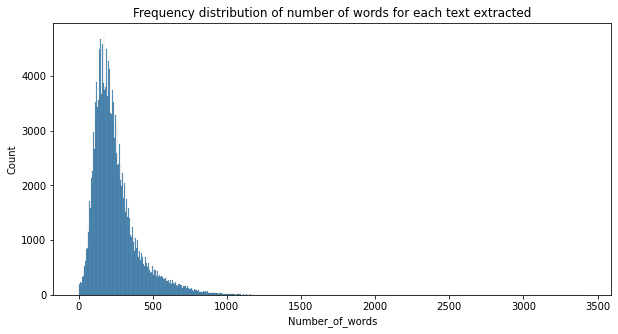

In [9]:
plt.figure(figsize=(10,5))
sns.histplot(df['Number_of_words'])
plt.title("Frequency distribution of number of words for each text extracted");

In [10]:
df['SName'] = df['SName'].astype(str)
df['SName']

0                                          Careless Whisper
1         Could You Be Loved / Citação Musical do Rap: S...
2                                    Cruisin' (Part. Saulo)
3                                                      Easy
4                         For Your Babies (The Voice cover)
                                ...                        
191809                                          The Waiting
191810                                Too Early For The Sky
191811        Warsaw 1943 (I Never Betrayed The Revolution)
191812                           When The System Has Fallen
191813                                  Woman Be My Country
Name: SName, Length: 191814, dtype: object

---
## Clean up title and lyric

In [11]:
# remove \n in lyric
df['Lyric'] = df['Lyric'].apply(lambda x: re.sub("\n", ' ', x).lower())

In [12]:
# remove sub-contant in name
# i.e '()', '/'
df['SName'] = df['SName'].apply(lambda x: x.split('(')[0].strip().lower())
df['SName']

0                                          careless whisper
1         could you be loved / citação musical do rap: s...
2                                                  cruisin'
3                                                      easy
4                                           for your babies
                                ...                        
191809                                          the waiting
191810                                too early for the sky
191811                                          warsaw 1943
191812                           when the system has fallen
191813                                  woman be my country
Name: SName, Length: 191814, dtype: object

In [13]:
def filter_title(x):
    splited_x = x.split('/')
    if len(splited_x)<=1:
        return x
    if not splited_x[1].isnumeric():
        return splited_x[0].strip()
    else:
        return x

In [14]:
df['SName']= df['SName'].apply(lambda x: filter_title(x))

In [15]:
df['SName']

0                   careless whisper
1                 could you be loved
2                           cruisin'
3                               easy
4                    for your babies
                     ...            
191809                   the waiting
191810         too early for the sky
191811                   warsaw 1943
191812    when the system has fallen
191813           woman be my country
Name: SName, Length: 191814, dtype: object

In [16]:
df.to_csv('clean.csv',index=False)

# Split

In [17]:
train, valid = df.iloc[:153119,:], df.iloc[153119:,:]
valid

,SName,Lyric,Number_of_words,Number_of_words_title
153119,every christian lion hearted man will show you,oh solo dominique oh solo dominique oh solo do...,124,8
153120,everybody is a fucking liar,everyone i know is trying to get into this sho...,167,5
153121,everyone moves away,"please forgive, for they know not what they've...",265,3
153122,fall apart with me,"oooh, met you in the summer in the summer wave...",182,4
153123,fall song,it's too nice to breathe and i was feeling dir...,249,2
...,...,...,...,...
191809,the waiting,chorus here we stand waiting on the plain dark...,198,2
191810,too early for the sky,i nearly disappeared into the mouth of a croco...,137,5
191811,warsaw 1943,"amambuka, amambuka azothengisa izwe lakithi, i...",221,7
191812,when the system has fallen,sweat in the heat for days on end waiting for ...,260,5


## Inference

In [18]:
def generate(lyric):
        
    tokenizer = AutoTokenizer.from_pretrained("victorlifan/autotrain-song_title_generate-939531516")
    model = AutoModelForSeq2SeqLM.from_pretrained("victorlifan/autotrain-song_title_generate-939531516")
    
    inputs = tokenizer.encode("summarize: " + lyric, return_tensors="pt")
    outputs = model.generate(inputs, max_length=24, min_length=1, length_penalty=2.0, num_beams=4, early_stopping=True)
    result = tokenizer.decode(outputs[0])
    return result

In [19]:
# inference on valid set
for idx in np.random.randint(valid.index.min(),valid.index.max(),size=5):
    lyric = df['Lyric'][idx]
    title = generate(lyric)
    
    print(f"song id: {idx}\n")
    print(f"actual title: {df['SName'][idx]}\n")
    print(f"generated title: {title}\n")
    print(f"lyrics: {df['Lyric'][idx]}\n")
    print('='*50)

song id: 154812

actual title: for you blue

generated title: <pad> because you're sweet</s>

lyrics: because you're sweet and lovely girl i love you, because you're sweet and lovely girl it's true, i love you more than ever girl i do.  i want you in the morning girl i love you, i want you at the moment i feel blue, i'm living ev'ry moment girl for you.  i've loved you from the moment that i saw you, you looked at me that's all you had to do, i feel it now i hope you feel it too.  because you're sweet and lovely girl i love you, because you're sweet and lovely girl it's true, i love you more than ever girl i do.

song id: 157715

actual title: the struggle

generated title: <pad> the struggle</s>

lyrics: by ana lu  the struggle  the struggle is in our hearts it's in our hands so whom do we really serve what can we trust what have we planned firmly fix your heart your mind will follow ever longing everlasting the truth is sometimes hard to swallow we all understand the choice is in our

Token indices sequence length is longer than the specified maximum sequence length for this model (676 > 512). Running this sequence through the model will result in indexing errors


song id: 179321

actual title: right now

generated title: <pad> right now</s>

lyrics: [john cena] yeah you can't help but feel it can't help but feel this one uh-huh uh yeah  excuse me for a minute while i lighten the mood just clap with me like the lightning do, yeah a bit of soul food that you be bitin into and if you feel me then i'm writin for you, uh-huh right now put another coat of wax on the ride for a minute put the beef and the gats to the side cause this track's got a vibe to chill to enjoy life for 5 minutes, man it's not gon' kill you it's okay to be hard and stay true man but at the end of the day, we all hu-man this one's for you, the ones that you close to show some love, it's what you supposed to right now, forget the ends and the benz pop a cold one, man toast it wit'cha real friends call your folks, tell 'em you tight now cause everything lookin pretty good right now  [chorus - sped up vocal sample]  [tha trademarc] right now baby, we all gon' ride so place those t

## inference on billboard top3 songs
1. As It Was by Harry Styles
2. First Class by Jack Harlow
3. Wait For U by Future Featuring Drake & Tems

In [20]:
# inference on billboard top song, i.e As It Was (Harry Styles)
As_It_Was = '''Holdin' me back
Gravity's holdin' me back
I want you to hold out the palm of your hand
Why don't we leave it at that?
Nothin' to say
When everything gets in the way
Seems you cannot be replaced
And I'm the one who will stay, oh
In this world, it's just us
You know it's not the same as it was
In this world, it's just us
You know it's not the same as it was
As it was, as it was
You know it's not the same
Answer the phone
"Harry, you're no good alone
Why are you sittin' at home on the floor?
What kind of pills are you on?"
Ringin' the bell
And nobody's comin' to help
Your daddy lives by himself
He just wants to know that you're well, oh
In this world, it's just us
You know it's not the same as it was
In this world, it's just us
You know it's not the same as it was
As it was, as it was
You know it's not the same
Go home, get ahead, light-speed internet
I don't wanna talk about the way that it was
Leave America, two kids follow her
I don't wanna talk about who's doin' it first
As it was
You know it's not the same as it was
As it was, as it was
'''
generate(As_It_Was)

'<pad> as it was</s>'

In [21]:
First_Class = '''Mm
I been a (G), throw up the (L)
Sex in the (A-M), uh-huh
(O-R-O-U-S, yeah)
And I can put you in (first class, up in the sky)
I can put you in (first class, up in the, up-up in the)
I been a (G), throw up the (L)
Sex in the (A-M), uh-huh
(O-R-O-U-S, yeah)
And I can put you in (first class, up in the sky), mm, mm
I can put you in (first class, up in the, up-up in the)
I can see the whole city from this balcony
Back in 2019, I was outside freely
But now they got it out for me
I don't care what frat that you was in
You can't alpha me, keep dreamin'
Pineapple juice, I give her sweet, sweet, sweet (semen)
I know what they like, so I just keep cheesin'
Hard drive full of heat seekin'
Tryna come the same day as Jack? Rethink it
You don't need Givenchy, you need Jesus
Why do y'all sleep on me? I need reasons
Uh, I got plaques in the mail, peak season
Shout out to my UPS workers makin' sure I receive 'em
You can do it too, believe it
I been a (G), throw up the (L)
Sex in the (A-M), uh-huh
(O-R-O-U-S, yeah)
And I can put you in (first class, up in the sky), mm, mm
I can put you in (first class, up in the, up-up in the)
Huh, yes, I am
They say, "You a superstar now, " damn, I guess I am
You might be the man, well, that's unless I am
Okay, I'll confess I am
Go ahead and get undressed, I am
Okay cool, you on Sunset? (I am)
I'm 'bout to slide, okay, I'm outside, okay
This lifestyle don't got many downsides
'Cept for the lack of time I get 'round my
Family, makin' sure they never downsize
I got visions of my mom sayin', "Wait, this house mine?"
Can't lie, I'm on Angus Cloud nine
I got 'em on the bandwagon now, 'bout time
I ain't even got no downtime
Every time I speak, she say, "Yeah, that sounds fine"
I been a (G), throw up the (L)
Sex in the (A-M), uh-huh
(O-R-O-U-S, yeah)
And I can put you in (first class, up in the sky)
I can put you in (first class, up in the, up-up in the)
I been a (G), throw up the (L)
Sex in the (A-M), uh-huh
(O-R-O-U-S, yeah)
And I can put you in (first class, up in the sky), mm, mm
I can put you in (first class)
'''
generate(First_Class)

Token indices sequence length is longer than the specified maximum sequence length for this model (748 > 512). Running this sequence through the model will result in indexing errors


'<pad> first class</s>'

In [22]:
Wait_For_U = '''Early in the morning, late at night (I will wait for you)
It don't even matter what time it is (I will wait for you)
Presidential Rollie already on the way (tired, sayin', "Aye, yi, yi, yi")
Whenever I find time, it's okay (ayy)
(ATL Jacob, ATL Jacob)
You pray for my demons, girl, I got you
Every time I sip on codeine, I get vulnerable
Ignoring the sounds of the storm when it come
She understand I can't take her everywhere a nigga going
I been in the field like the children of the corn
I can hear your tears when they drop over the phone
Get mad at yourself 'cause you can't leave me alone
Gossip, bein' messy, that ain't what we doing (worried 'bout a Xanny)
Travel around the world (would you brag, or would you try to get me?)
Over the phone, dropping tears (tell me now, I know that you be bragging)
I get more vulnerable when I do drugs (tell me now, I need you so bad, yeah)
When you drunk, you tell me exactly how you feel (I will wait for you, for you)
When I'm loaded, I keep it real (I will wait for you, I will wait for you)
Please tell a real one exactly what it is (I will wait, will wait, for you, for you)
Don't say it 'cause you know that's what I wanna hear (I will wait for you, I will wait for you)
Yeah, I been trapping 'round the world
I sit on my balcony and wonder how you feeling
I got a career that takes my time away from women
I cannot convince you that I love you for a living (will wait for you, for you)
I be on your line, feelings flowing like a river
You be texting back you at Kiki on the river (I will wait for you)
Message say "Delivered"(I will wait for you), but I know that you 'on't get it
Why you introduce us if you knew that you was with him? (I will wait for you, for you, for you)
Made me shake his hand when y'all been fucking for a minute (I will wait for you, for you)
Walk me off the plank because you know that I'm a swimmer (I will wait for you)
Supposed to be your dawg, but you done put me in a kennel
Girl, put a muzzle on it, all that barking over dinner
I was fucking with you when you had the tiny Presidential
You got better when you met me and that ain't coincidental
Tried to bring the best out you but, guess I'm not that influential
Guess I'm not the one that's meant for you
I can hear your tears when they drop over the phone
Get mad at myself 'cause I can't leave you alone
Gossip, that messy shit, that ain't what we doing, yeah (worried 'bout a Xanny)
Trapping around the world (would you brag, or would you try to get me?)
Over the phone, dropping tears (tell me now, I know that you be bragging)
I get more vulnerable when I do pills (tell me now, I need you too bad, yeah)
When you drunk, you tell me exactly how you feel (I will wait for you, for you)
When I'm loaded, I keep it real (I will wait for you, I will wait for you)
Please tell a real one exactly what it is (I will wait, will wait, for you, for you)
Don't say it 'cause you know that's what I wanna hear (I will wait for you, I will wait for you)
Early in the morning, late at night
It don't even matter what time it is
(Worried 'bout a Xanny, would you brag, or would you try to get me?)
(Tell me now, I know that you be bragging)
(Tell me now)'''
generate(Wait_For_U)

Token indices sequence length is longer than the specified maximum sequence length for this model (950 > 512). Running this sequence through the model will result in indexing errors


'<pad> presidential rollie</s>'

### edge case: N95 by Kendrick Lamar

In [23]:
# edge case: N95 by Kendrick Lamar
N95 = '''Hello, new world, all the boys and girls
I got some true stories to tell
You're back outside, but they still lied
Whoa, oh, oh, oh (yeah)
Take off the foo-foo
Take off the clout chase
Take off the Wi-Fi
Take off the money phone
Take off the car loan
Take off the flex and the white lies
Take off the weird-ass jewelry
I'ma take ten steps
Then I'm takin' off top five
Take off them fabricated streams
And them microwave memes
It's a real world outside (take that shit off)
Take off your idols
Take off the runway
I take off to Cairo (take that shit off)
Take off to Saint-Tropez
Five day stay, take a quarter mil'
Hell, if I know (take that shit off)
Take off the false flag
Take off perception
Take off the cop with the eye patch (take that shit off)
Take off the unloyal
Take off the unsure
Take off decisions I lack (take it off)
Take off the fake deep
Take off the fake woke
Take off the I'm broke, I care (take it off)
Take off the gossip
Take off the new logic, that if I'm rich, I'm rare (take it off)
Take off the Chanel
Take off the Dolce
Take off the Birkin bag (take it off)
Take all that designer bullshit off
And what do you have? (Bitch)
Huh, huh, uh, you ugly as fuck
(You out of pocket)
Huh, two ATMs (hah, hah, hah, hah)
You steppin' or what? (You out of pocket, huh)
Who you think they talk 'bout?
Talk about us (you out of pocket, shoot, shoot, shoot)
Who you think they copy off? (Brrt, brrt, brrt, brrt)
Copy off us (get back in pocket)
The world in a panic
The women is stranded
The men on a run
The prophets abandoned
The Lord take advantage
The market is crashin'
The industry wants
Niggas and bitches to sleep in a box
While they makin' a mockery followin' us
This ain't Monopoly
Watchin' for love
This ain't monogamy
Y'all gettin' fucked
Jumpin' on what the hell is that?
I gotta relax when I feel (huh, facts)
All of my descendants
They come in my sleep and say I am too real (huh, facts)
I'm done with the sensitive takin' it personal
Done with the black and the white
The wrong and the right
You hopin' for change and clericals
I know the feelings that came with burial's cries (bitch)
Huh, huh, uh, you ugly as fuck
(You out of pocket)
Huh, two ATMs (hah, hah, hah, hah)
You steppin' or what? (You out of pocket, huh)
Who you think they talk 'bout?
Talk about us (you out of pocket, shoot, shoot, shoot)
Who you think they copy off?
Copy off us (brrt, brrt, brrt, brrt)
Servin' up a look, dancin' in the drought
Hello to the big stepper, never losin' count
Ventin' in the safe house, ventin' in the sa-, ahh
Can I vent all my truth?
I got nothin' to lose
I got problems and pools
I can swim in my faith
Camera's movin' whenever I'm movin'
The family suin' whatever I make
Murder is stackin', the president actin'
The government taxin' my funds in the bank
Homies attractin' the feds
When I'm brackin', look at my reaction
My pupils on skates (hold up, hold up)
Let's think about this for a second (let's go)
Tell me what you would do for aesthetic (let's go)
Would you sell your soul on credit? (Let's go)
Would you sell your bro for leverage? (Let's go)
Where the hypocrites at?
What community feel
They the only ones relevant? (Let's go)
Where the hypocrites at?
What community feel
They the only ones relevant? (Let's go)
You outta pocket, yeah, you outta pocket (this shit hard)
You entertain the mediocre, need to stop it (this shit hard)
You entertainin' old friends when they toxic (this shit hard)
What's your life like? Bullshit and gossip (this shit hard)
What the fuck is cancel culture, dawg?
Say what I want about you niggas
I'm like Oprah, dawg
I treat you crackers like I'm Jigga, watch
I own it all
Oh, you worried 'bout a critic?
That ain't protocol (bitch)'''
generate(N95)

Token indices sequence length is longer than the specified maximum sequence length for this model (1169 > 512). Running this sequence through the model will result in indexing errors


'<pad> take it off</s>'

In [24]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/pegasus-xsum")

model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-xsum")

In [25]:
idx = 459
article = df['Lyric'][idx]

inputs = tokenizer.encode("summarize: " + article, return_tensors="pt",max_length=512)
outputs = model.generate(inputs, max_length=10, min_length=1, length_penalty=2.0, num_beams=4, early_stopping=True)
result = tokenizer.decode(outputs[0])
print(result)
print(df['SName'][idx])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<pad>hanna: i guess you know i'</s>
bad girl
